In [1]:
%matplotlib ipympl

import numpy as np
import cv2
import os
import struct
import matplotlib.pyplot as plt

In [2]:
# Set crucial parameters
layer_height = 0.16 # 0.16 or 0.20mm are default slicer settings
line_width = 0.4 # 0.42mm is default slicer setting
max_dim = 100 # mm, desired maximum dimension of 3D printed image

min_thickness = layer_height * 2
max_thickness = layer_height * 18

In [3]:
FIGURES = []
def show_img(img, fig_name=None, cmap=None):
    FIGURES.append(plt.figure(fig_name))
    plt.axis('off')
    plt.imshow(img, cmap=cmap)
    plt.show()

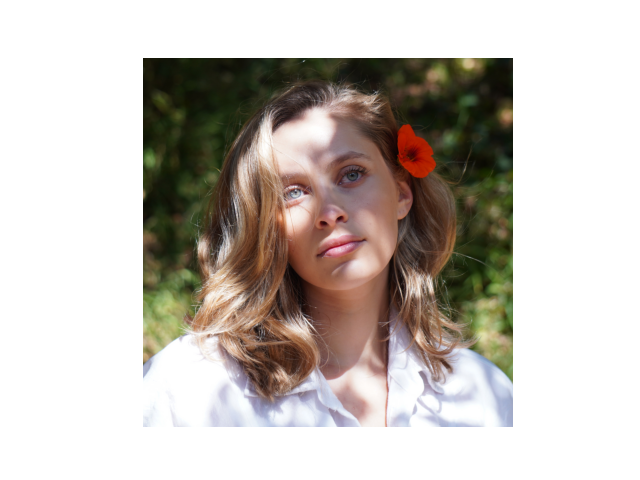

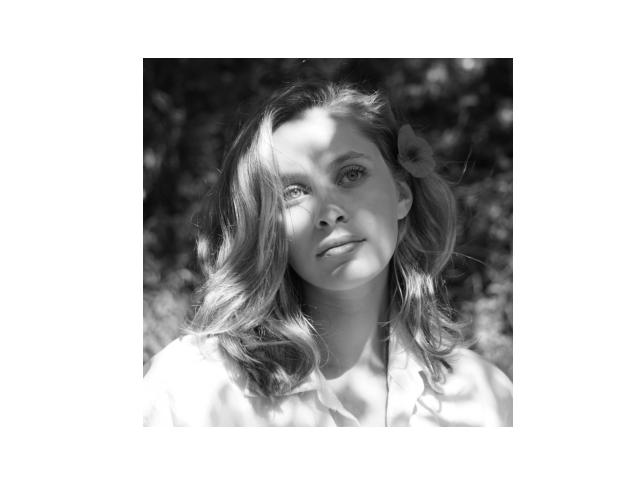

In [4]:
image_path = r"assets\DSC02666_square.JPG"
image_path = image_path.replace("\\\\", os.sep)

img_bgr = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_gry = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

show_img(img_rgb, fig_name=f'Full RGB Image: {image_path}')
show_img(img_gry, fig_name='Grayscale',cmap='gray')

Resizing image from (3795, 3795) to (249, 249)
possible range: 0.32mm - 2.88mm
value range: 0.32mm - 2.839843137254902mm


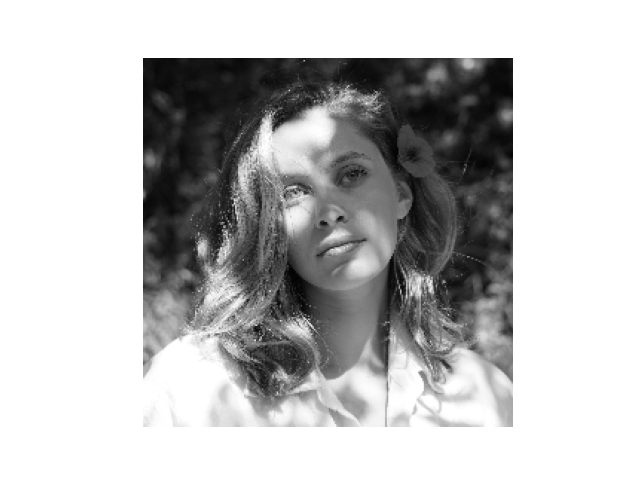

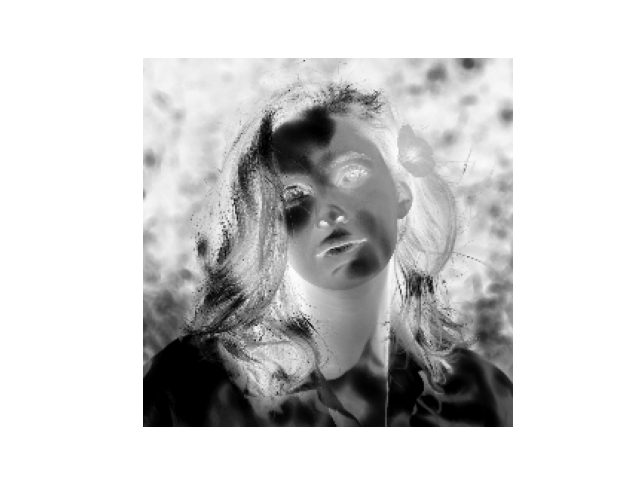

In [5]:
# Transform Image
ogH, ogW = img_rgb.shape[:2]

long_res = max_dim // line_width
ratio = max(ogH, ogW) / min(ogH, ogW)
short_res = long_res // ratio

H, W = (int(short_res), int(long_res)) if ogH < ogW else (int(long_res), int(short_res))

# Resize Image
print(f'Resizing image from ({ogH}, {ogW}) to ({H}, {W})')
img_rsz = cv2.resize(img_gry, (W, H), interpolation=cv2.INTER_LINEAR)

# Originally planned to posterize image to fit neatly into layers,
# but this will happen for free in slicer anyway. However, 
# if combined with other filters later, it might create a good effect

"""
# Posterize Image
img_pst = np.ceil(img_rsz / (255 / n_values)).astype(np.uint8)
show_img(img_pst, cmap='gray')

"""

# Invert and re-scale image
img_thk = min_thickness + (1.0 - img_rsz / 255.0) * (max_thickness - min_thickness)

print(f'possible range: {min_thickness}mm - {max_thickness}mm')
print(f'value range: {np.min(img_thk)}mm - {np.max(img_thk)}mm')

show_img(img_rsz, fig_name='Resized Image', cmap='gray')
show_img(img_thk, fig_name='Thickness Image', cmap='gray')

In [6]:
class STL_Tri:
    def __init__(self, v1=None, v2=None, v3=None, normal=None):
        # v1 -> v2 -> v3 must be defined in a counter-clockwise manner,
        # such that the right-handed normal vector points outward from object interior
        self.v1 = v1
        self.v2 = v2
        self.v3 = v3

        # If normal is set at instantiation, then we won't implicitly compute it from vertices
        self.normal = normal
        self.recompute_normal = normal is None

        self.__zero_area = None
        self.compute_normal()

    def compute_normal(self):
        if not self.recompute_normal:
            return
        
        if any(x is None for x in [self.v1, self.v2, self.v3]):
            return
        
        normal = np.cross((self.v2-self.v1),(self.v3-self.v2))
        length = np.linalg.norm(normal)

        self.__zero_area = length == 0
        if self.__zero_area: 
            return

        self.normal = normal / length

    def compute_area(self):
        return 0.5 * np.linalg.norm(np.abs(np.cross(self.v2 - self.v1, self.v3 - self.v1)))
    
    def zero_area(self):
        return self.__zero_area if self.__zero_area is not None else self.compute_area() == 0.0
    


In [7]:
# Create array of 3D coordinates (in mm) to house image vertex data
X, Y = np.meshgrid(np.arange(0,W), np.arange(0,H))
X = X.ravel() * line_width
Y = line_width * ((H - 1) - Y.ravel())

verts = np.zeros((H * W, 3), dtype=np.float32)

verts[:,0] = X
verts[:,1] = Y
verts[:,2] = img_thk.flatten()

In [8]:
# COMPUTE NUMBER OF TRIANGLES TO BE IN MESH
num_tri_img = 2 * (H - 1) * (W - 1) # number of triangle in picture mesh
print(f'Image-area triangle count: {num_tri_img}')

# Compute number of tris on each side
# 1) Same grid-based method as image side on upper region of side wall
# 2) Fan triangulation method on lower portion of sides, to go from many edges to one at the interface with bottom
num_tri_sides_upper = 4 * (H + W) - 8
num_tri_sides_lower = 2 * (H + W)
num_tri_sides = num_tri_sides_upper + num_tri_sides_lower
print(f'Sides triangle count: {num_tri_sides}')

# No. of tris on bottom side is just two (comprises square) to keep things simple
num_tri_bottom = 2
print(f'Bottom surface triangle count: {num_tri_bottom}')

# Add up total
num_tri = num_tri_img + num_tri_sides + num_tri_bottom
print(f'Total Triangle count: {num_tri}')

# Preallocate Triangle list
tris_img  = [STL_Tri()] * num_tri_img
tris_base = [STL_Tri()] * (num_tri_sides + num_tri_bottom)

Image-area triangle count: 123008
Sides triangle count: 2980
Bottom surface triangle count: 2
Total Triangle count: 125990


In [9]:
### IMAGE MESH
# Assemble Image mesh as squares with triangle subcomponents:
#   v1---v2
#    | / |
#   v3---v4

v_idx = 0
t_idx = 0

while t_idx < num_tri_img:
    # When reach end of row, skip forward. There's no tri right of this pixel
    if (v_idx + 1) % W == 0:
        v_idx += 1

    # Get verts comprising the 2-tri quad between pixel positions
    v1 = verts[v_idx,:]
    v2 = verts[v_idx + 1, :]
    v3 = verts[v_idx + W, :]
    v4 = verts[v_idx + W + 1, :]

    # Create 2 tris of the quad
    tris_img[t_idx] = STL_Tri(v1, v3, v2); t_idx += 1
    tris_img[t_idx] = STL_Tri(v2, v3, v4); t_idx += 1

    v_idx += 1

In [10]:
### Create the indices for the base verts, starting with the four corners of the bottom of the base
n_verts_base = 2 * (H + W)
verts_base = np.zeros((n_verts_base, 3), dtype=np.float32)

# From top view:
#   1---2
#   | / |
#   4---3
#
# Correct order (since upside-down): 1->2, 2->3

extents = [(H - 1) * line_width, (W - 1) * line_width]

# [X,Y,Z] verts
verts_base[0,:] = [0.0, extents[0], 0.0]        # v1
verts_base[1,:] = [extents[1], extents[0], 0.0] # v2
verts_base[2,:] = [extents[1], 0.0, 0.0]        # v3
verts_base[3,:] = [0.0, 0.0, 0.0]               # v4

tris_base[0] = STL_Tri(verts_base[0,:], verts_base[1,:], verts_base[3,:], normal=[ 0.0,  0.0, -1.0])
tris_base[1] = STL_Tri(verts_base[1,:], verts_base[2,:], verts_base[3,:], normal=[ 0.0,  0.0, -1.0])

<!-- ![sidwall triangulation](assets/Sidewall_Method.jpg "Sidewall Triangulation Method") -->
### Sidewall Triangulation Method
<img src="assets/Sidewall_Method.jpg" alt="Sidewall Triangulation Method" width="400"/>

In [11]:
### create verts for the sides of the base
Z = min_thickness

# Append with vertices going CW from top view around outer edge,
# starting with top left

X = np.arange(0, W) * line_width
Y = ((H - 1) - np.arange(0, H)) * line_width

# Top side
start = 4
verts_base[start:start+W,0] = X
verts_base[start:start+W,1] = Y[0]
verts_base[start:start+W,2] = Z

# R side
start += W
verts_base[start:start+H-1,0] = X[-1]
verts_base[start:start+H-1,1] = Y[1:]
verts_base[start:start+H-1,2] = Z

# Bottom side
start += H-1
verts_base[start:start+W-1,0] = X[::-1][1:]
verts_base[start:start+W-1,1] = 0.0
verts_base[start:start+W-1,2] = Z

# L side
start += W-1
verts_base[start:start+H-1,0] = 0.0
verts_base[start:start+H-1,1] = Y[::-1][1:-1]
verts_base[start:start+H-1,2] = Z

In [12]:
# Base side, upper triangulation

# When viewed from inside out, we need normals pointing out
#   v1---v2
#    | / |
#   v3---v4
# thus, for this configuration, the correct order is 1>2>3 for top and 2>4>3 for bottom

# NOTE: normals and verts_step change with each side we move along, going CW from top side

# Normal vectors for each side of the base along each wall
normals = np.array([[ 0.0,  1.0, 0.0],
                    [ 1.0,  0.0, 0.0],
                    [ 0.0, -1.0, 0.0],
                    [-1.0,  0.0, 0.0]])

# Step size (and direction) to take along image verts to align with correct verts_base entry when triangulating
verts_step = [1, W, -1, -W]

vb_idx = 4 # index into verts_base
vi_idx = 0 # index into verts (image verts)
t_idx = 2  # index into tris_base

for side in range(4):
    
    dim_size = H if side % 2 else W

    for i in range(dim_size - 1):
        
        v1 = verts[vi_idx]
        v2 = verts[vi_idx + verts_step[side]]
        v3 = verts_base[vb_idx]
        vb_idx = (vb_idx + 1) if vb_idx < (n_verts_base-1) else 4
        v4 = verts_base[vb_idx]
                
        vi_idx += verts_step[side]
        nor = normals[side,:]

        tris_base[t_idx] = STL_Tri(v1, v2, v3, normal=None); t_idx += 1
        tris_base[t_idx] = STL_Tri(v2, v4, v3, normal=None); t_idx += 1

In [13]:
# Final Triangulation Step: Fan method between base 4 verts and the min_thickness layer
vb_idx = 4
t_start = t_idx

# Normal vectors for each side of the base along each wall
normals = np.array([[ 0.0,  1.0, 0.0],
                    [ 1.0,  0.0, 0.0],
                    [ 0.0, -1.0, 0.0],
                    [-1.0,  0.0, 0.0]])

for side in range(4):

    v_bottom = verts_base[side]

    dim_size = H if side % 2 else W

    for i in range(dim_size - 1):

        v1 = verts_base[vb_idx]
        vb_idx = (vb_idx + 1) if vb_idx < (n_verts_base-1) else 4
        v2 = verts_base[vb_idx]
        v3 = v_bottom

        tris_base[t_idx] = STL_Tri(v1, v2, v3, normal=normals[side,:]); t_idx += 1
    
    v1 = verts_base[vb_idx]
    v2 = verts_base[(side + 1) % 4]
    v3 = v_bottom

    tris_base[t_idx] = STL_Tri(v1, v2, v3, normal=normals[side,:]); t_idx += 1

In [14]:
### PLOT Verts from Tris for debugging purposes
if line_width > 10:
    # Get verts from tri sides
    base_verts_from_tri = np.zeros((3*len(tris_base),3))
    for i, tri in enumerate(tris_base):
        base_verts_from_tri[i*3:i*3+3, :] = np.array([tri.v1, tri.v2, tri.v3])

    img_verts_from_tri = np.zeros((3*len(tris_img),3))
    for i, tri in enumerate(tris_img):
        img_verts_from_tri[i*3:i*3+3, :] = np.array([tri.v1, tri.v2, tri.v3]); 

    colors = 1 - (img_verts_from_tri[:,2] - min_thickness) / (max_thickness - min_thickness)
    colors = np.clip(colors, 0, 1)
    colors = [(x,x,x) for x in colors]

    # 3D scatterplot of tri verts
    fig = plt.figure(facecolor='darkgrey', figsize=[7.5,7.55])
    ax = fig.add_subplot(projection='3d')
    ax.set_facecolor('darkgrey') 

    ax.view_init(elev=90, azim=-90, roll=0)
    proj_types = ['ortho','persp']
    ax.set_proj_type(proj_types[0])

    plt.axis('scaled')

    ax.scatter(base_verts_from_tri[:,0], base_verts_from_tri[:,1], base_verts_from_tri[:,2], marker='.', c='r', s=28)
    ax.scatter(img_verts_from_tri[:,0].ravel(), img_verts_from_tri[:,1].ravel(), img_verts_from_tri[:,2].ravel(), marker='s', c=colors)#colors, s=10)

    ax.set_xlim(0, max_dim)
    ax.set_ylim(0, max_dim)
    ax.set_zlim(0, max_thickness)
    plt.show()


In [15]:
def write_binary_stl(filename, facets):
    
    problem_cnt = 0    
    # Open file and set to write in binary
    with open(filename, 'wb') as f:
        
        # ASCII header (can/will be empty)
        f.write(b'\x00' * 80)

        # Write number of facets
        f.write(struct.pack('<I', len(facets))) # <I for little-endian unsigned

        # Write each facet
        for i, tri in enumerate(facets):

            if tri.zero_area():
                continue

            if any([prop is None for prop in [tri.v1, tri.v2, tri.v3, tri.normal]]):
                problem_cnt += 1
                continue

            if tri.v1[2] < 0 or tri.v2[2] < 0 or tri.v3[2] < 0:
                print('<0')
                problem_cnt += 1
                continue

            # Pack normal vector (3x float)
            f.write(struct.pack('<fff', tri.normal[0], tri.normal[1], tri.normal[2]))

            # Pack verts (3x(3x floats))
            f.write(struct.pack('<fff', tri.v1[0], tri.v1[1], tri.v1[2]))
            f.write(struct.pack('<fff', tri.v2[0], tri.v2[1], tri.v2[2]))
            f.write(struct.pack('<fff', tri.v3[0], tri.v3[1], tri.v3[2]))

            # Pack attribute byte count (2-byte unsigned short, usually 0)
            f.write(struct.pack('<H', 0))

    print(f'Wrote binary STL file {filename} with {len(facets)} facets')

    if problem_cnt > 0:
        raise Exception(f'{problem_cnt} facets had problems and were omitted from the model!')

In [16]:
num_failed = write_binary_stl(filename='subsurface.stl', facets= tris_img + tris_base)

Wrote binary STL file subsurface.stl with 125990 facets
